# 3. 소프트맥스 회귀의 비용 함수 구현하기

In [1]:
import torch
import torch.nn.functional as F

In [37]:
torch.manual_seed(1)

## 3-1. 파이토치로 소프트맥스의 비용 함수 구현하기( Low - Level)

In [38]:
z = torch.FloatTensor([1,2,3])

In [39]:
hypothesis = F.softmax(z,dim = 0)

In [40]:
print(hypothesis)
print(hypothesis.sum())

tensor([0.0900, 0.2447, 0.6652])
tensor(1.)


### 비용함수 직접 구현하기

In [41]:
z = torch.rand(3,5, requires_grad = True)

In [42]:
hypothesis = F.softmax(z,dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [43]:
y = torch.randint(5,(3,)).long()

In [44]:
print(y)

tensor([0, 2, 1])


In [45]:
y_ohe = torch.zeros_like(hypothesis) ### 모든 원소가 0인 3*5 텐서 생성x

In [46]:
y_ohe.scatter_(1,y.unsqueeze(1),1)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

- y.unsqueeze(1)을 하면 (3,) 크기를 가졌던 y텐서는 3*1 텐서가 된다.
- scatter의 첫번째 인자로 dim = 1에 대해서 수행
- 세번째 인자 1은 두번째 인자인 y.unsqueeze(1)이 알려주는 위치에 숫자 1을 넣는다.
- 연산 뒤에 _를 붙이면 덮어쓰기 연산이다.

In [47]:
print(y.unsqueeze(1))

tensor([[0],
        [2],
        [1]])


In [48]:
print(y_ohe)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


In [49]:
cost = (y_ohe * - torch.log(hypothesis)).sum(dim = 1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


## 3-2. F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [51]:
(y_ohe * - F.log_softmax(z,dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [52]:
F.nll_loss(F.log_softmax(z,dim=1),y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

- nll : Negative Log Likelihood

In [53]:
F.cross_entropy(z,y)

tensor(1.4689, grad_fn=<NllLossBackward0>)

# 5. 소프트맥스 회귀로 MNIST 데이터 분류하기

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [2]:
random.seed(777)
torch.manual_seed(777)

In [3]:
training_epochs = 15
batch_size = 100

In [4]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train = True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



- root : MNIST 데이터 다운로드 받을 경로
- train : True로 하면 MNIST 훈련 데이터 리턴
- transform : 현재 데이터를 파이토치 텐서로 변환
- download : 해당경로에 MNIST없다면 다운로드 받겠다는 의미

In [5]:
data_loader = DataLoader(dataset=mnist_train,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

- drop_last : 마지막 배치를 버릴 것인지를 의미
- 마지막 배치가 batch_size보다 작을 경우 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아준다.

In [6]:
linear = nn.Linear(784,10,bias=True)

- mnist 사이즈가 28*28 = 784이기때문에 784로 했고 0~9까지 값을 맞추는 것이기에 output_dim은 10으로 했다.
- bias는 편향 사용할 것인지

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear.parameters(),lr = 0.1)

- nn.functional.cross_entropy()나 위의 것이나 둘 다 소프트맥스 함수 포함

In [17]:
for epoch in range(training_epochs) :
    avg_cost = 0
    total_batch = len(data_loader) ## len(mnist_train) / len(batch_size)
    
    for X,y in data_loader :
        X = X.view(-1,28*28)
        y = y
        
        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis,y)
        cost.backward()
        optimizer.step()
        
        
        avg_cost += cost / total_batch
        
    print(f"Epoch : {epoch+1}, cost = {avg_cost}")
    
print('Learning Finished...')

Epoch : 1, cost = 0.53570157289505
Epoch : 2, cost = 0.35940316319465637
Epoch : 3, cost = 0.33112993836402893
Epoch : 4, cost = 0.31661084294319153
Epoch : 5, cost = 0.3072877526283264
Epoch : 6, cost = 0.30015116930007935
Epoch : 7, cost = 0.29512885212898254
Epoch : 8, cost = 0.2905261516571045
Epoch : 9, cost = 0.28743141889572144
Epoch : 10, cost = 0.28442883491516113
Epoch : 11, cost = 0.28172606229782104
Epoch : 12, cost = 0.279582142829895
Epoch : 13, cost = 0.2776218354701996
Epoch : 14, cost = 0.27599993348121643
Epoch : 15, cost = 0.2743197977542877
Learning Finished...


Accuracy :  0.8833000063896179
Label : 9

Prediction : 9



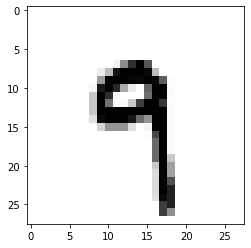

In [27]:
with torch.no_grad() : # no_grad는 gradient 수행 x
    X_test = mnist_test.test_data.view(-1,28*28).float()
    y_test = mnist_test.test_labels
    
    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction,1) == y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy : ',accuracy.item())
    
    r = random.randint(0, len(mnist_test)-1) ## mnist 테스트 데이터에서 무작위 하나 뽑아서 예측
    X_single = mnist_test.test_data[r:r+1].view(-1, 28*28).float()
    y_single = mnist_test.test_labels[r:r+1]
    
    print(f"Label : {y_single.item()}\n")
    single_prediction = linear(X_single)
    
    print(f"Prediction : {torch.argmax(single_prediction,1).item()}\n")
    plt.imshow(mnist_test.test_data[r:r+1].view(28,28),cmap='Greys',interpolation='nearest')
    plt.show()